Student Name: Ting Gu

Student zID: z5475872

In [1]:
import pandas as pd

# load data and display
df = pd.read_csv('dataset.tsv', sep='\t')
pd.set_option('display.width', 180)
pd.set_option('display.max_colwidth', 140)
df.head()

,artist_name,track_name,release_date,genre,lyrics,topic
0,loving,the not real lake,2016,rock,awake know go see time clear world mirror world mirror magic hour confuse power steal word unheard unheard certain forget bless angry we...,dark
1,incubus,into the summer,2019,rock,shouldn summer pretty build spill ready overflow piss moan ash guess smite leave remember call forever shouldn summer summer like coil v...,lifestyle
2,reignwolf,hardcore,2016,blues,lose deep catch breath think say try break wall mama leave hardcore hardcore think brother say lock bedroom sister say throw away world ...,sadness
3,tedeschi trucks band,anyhow,2016,blues,run bitter taste take rest feel anchor soul play game rule learn lessons get choose turn walk away walk away anytime anytime wake feel a...,sadness
4,lukas nelson and promise of the real,if i started over,2017,blues,think think different set apart sober mind sympathetic hearts swear oath swear oath know life play play distance great height sure kill ...,dark


In [3]:
df = df.drop_duplicates()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1480 entries, 0 to 1499
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   artist_name   1480 non-null   object
 1   track_name    1480 non-null   object
 2   release_date  1480 non-null   int64 
 3   genre         1480 non-null   object
 4   lyrics        1480 non-null   object
 5   topic         1480 non-null   object
dtypes: int64(1), object(5)
memory usage: 80.9+ KB


### Part 1

__Question 1__

For part (i), compare to the tutorial which the regex might remove too many special character, I choose to preserves apostrophes (') to keep words like I'm shoudn't, and I choose to preserves hyphens (-) to keep words connected by (-) so their meaning will not change.

Part (ii) answer will be in the next markdown cells.

__Question 2__

I choose to follow the preprocessing method from the tutorial, which uses lowercase, stop words, and stemming. I also tried deleting some of them to see whether the accuracy changes; it turns out there is no huge difference whether we use stop words, but theoretically, high‐frequency words will add noise. When I tried to delete stemming, the accuracy and F1-score of the BNB decreased. For the regex, as I describe in question 1 part(i), adding hyphens and apostrophes to keep some words' original meaning slightly increases the accuracy. Therefore, I choose to use the preprocessing ways followed by tutorials with minor changes in regex.

In [6]:
import nltk
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

nltk.download('stopwords')
nltk.download('punkt')

ps = PorterStemmer()
stop_words = set(stopwords.words('english'))

# Define preprocessing function
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r"[^a-z0-9'\-\s]", ' ', text)
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    tokens = [ps.stem(word) for word in tokens]
    return ' '.join(tokens)

# Apply preprocessing to each document
df['lyrics_cleaned'] = df['lyrics'].apply(preprocess_text)
print(df['lyrics'].head())

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\yee\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\yee\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


0    awake know go see time clear world mirror world mirror magic hour confuse power steal word unheard unheard certain forget bless angry we...
1    shouldn summer pretty build spill ready overflow piss moan ash guess smite leave remember call forever shouldn summer summer like coil v...
2    lose deep catch breath think say try break wall mama leave hardcore hardcore think brother say lock bedroom sister say throw away world ...
3    run bitter taste take rest feel anchor soul play game rule learn lessons get choose turn walk away walk away anytime anytime wake feel a...
4    think think different set apart sober mind sympathetic hearts swear oath swear oath know life play play distance great height sure kill ...
Name: lyrics, dtype: object


__Question 1__

For part (ii), the tutorial evaluation is based on only one training test split rather than using cross-validation. The code below uses the 5-fold cross-validation, and when it comes to the classification_report, it happens when the class never appears true in that fold, but we can't divide by zero in precision or recall calculation, so I added a zero_division=0 to avoid a certain scenario.

In [8]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score, classification_report
import numpy as np

# pipeline both using CountVectorizer
pipe_bnb = Pipeline([
    ('vect', CountVectorizer()),
    ('clf', BernoulliNB()),
])
pipe_mnb = Pipeline([
    ('vect', CountVectorizer()),
    ('clf', MultinomialNB()),
])

X = df['lyrics_cleaned']
y = df['topic']

#5-fold cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores_bnb = cross_val_score(pipe_bnb, X, y, cv=cv, scoring='accuracy')
scores_mnb = cross_val_score(pipe_mnb, X, y, cv=cv, scoring='accuracy')

# result
print(f"BNB accuracy: {scores_bnb.mean():.3f}")
cv_pred_bnb = cross_val_predict(pipe_bnb, X, y, cv=cv)
print(classification_report(y, cv_pred_bnb, zero_division=0))

print(f"MNB accuracy: {scores_mnb.mean():.3f}")
cv_pred_mnb = cross_val_predict(pipe_mnb, X, y, cv=cv)
print(classification_report(y, cv_pred_mnb))

BNB accuracy: 0.539
              precision    recall  f1-score   support

        dark       0.68      0.71      0.69       487
     emotion       0.00      0.00      0.00        79
   lifestyle       0.88      0.03      0.07       202
    personal       0.70      0.35      0.47       341
     sadness       0.41      0.87      0.56       371

    accuracy                           0.54      1480
   macro avg       0.53      0.39      0.36      1480
weighted avg       0.61      0.54      0.49      1480

MNB accuracy: 0.815
              precision    recall  f1-score   support

        dark       0.85      0.85      0.85       487
     emotion       0.86      0.38      0.53        79
   lifestyle       0.87      0.71      0.78       202
    personal       0.84      0.84      0.84       341
     sadness       0.74      0.90      0.81       371

    accuracy                           0.81      1480
   macro avg       0.83      0.73      0.76      1480
weighted avg       0.82      0.81    

__Question 3__

For different metrics, there are different pros and cons. I compare the results using accuracy, recall, and F1-score here. Accuracy measures the overall trend, but treats every example equally. But in our case, there is an imbalance in our dataset, emotion is a smaller set compared to others, so evaluating by accuracy is not a good idea. Precision measures the fraction of predicted positives that are actually correct, so it tells us how often our model’s predicts are truly on-target. Recall can handle an imbalanced dataset, but it doesn't consider false positives, it only measures the fraction of true positives that we successfully pick up. F1-score will be the best here, it penalizes a model both for low recall and for low precision, and it it way better than the raw accuracy in handling imbalanced dataset.

And in this case, MNB is superior. We can see from the graph, MNB has a higher value in all four of accuracy, precison, recall, and F1-score. We can also see from the second image, which is the similar frequency bar graph from the tutorial. It illustrates that BNB is only accurate on the topic of dark, whereas on other topics, MNB performs way better.

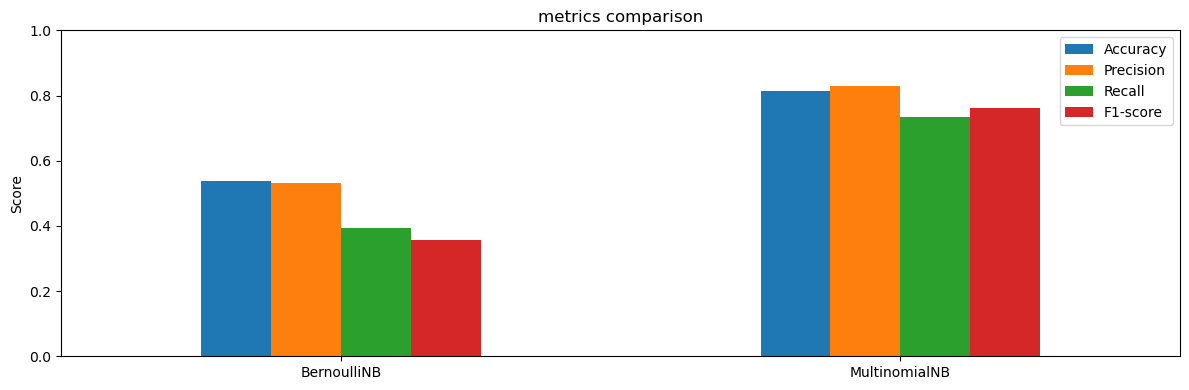

In [32]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import pandas as pd
import matplotlib.pyplot as plt

# get metrics result
bnb_acc = scores_bnb.mean()
mnb_acc = scores_mnb.mean()
bnb_prec = precision_score(y, cv_pred_bnb, average='macro', zero_division=0)
mnb_prec = precision_score(y, cv_pred_mnb, average='macro', zero_division=0)
bnb_recall = recall_score(y, cv_pred_bnb, average='macro', zero_division=0)
mnb_recall = recall_score(y, cv_pred_mnb, average='macro', zero_division=0)
bnb_f1 = f1_score(y, cv_pred_bnb, average='macro', zero_division=0)
mnb_f1 = f1_score(y, cv_pred_mnb, average='macro', zero_division=0)

# build dataframe 
df_metrics = pd.DataFrame({
    'Accuracy': [bnb_acc, mnb_acc],
    'Precision': [bnb_prec, mnb_prec],
    'Recall': [bnb_recall, mnb_recall],
    'F1-score': [bnb_f1, mnb_f1],
}, index=['BernoulliNB','MultinomialNB'])

# plot
ax = df_metrics.plot(kind='bar', figsize=(12,4), rot=0)
ax.set_ylim(0,1)
ax.set_ylabel('Score')
ax.set_title('metrics comparison')
plt.tight_layout()
plt.show()

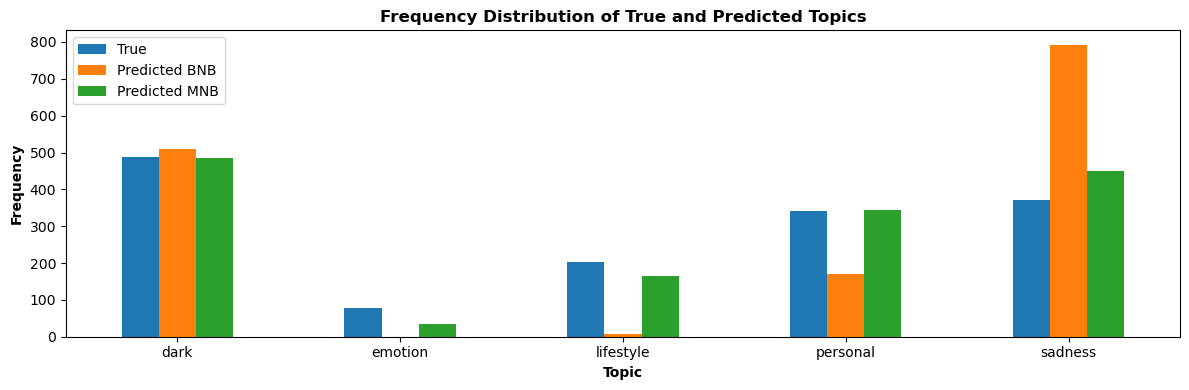

In [34]:
# dataframe for frequecy plot
df_dist = pd.DataFrame({
    'True': pd.Series(y).value_counts().sort_index(),
    'Predicted BNB': pd.Series(cv_pred_bnb).value_counts().sort_index(),
    'Predicted MNB': pd.Series(cv_pred_mnb).value_counts().sort_index(),
})

# plot
ax = df_dist.plot(kind='bar', figsize=(12,4), rot=0,)
plt.xlabel('Topic', fontweight='bold')
plt.ylabel('Frequency', fontweight='bold')
plt.title('Frequency Distribution of True and Predicted Topics', fontweight='bold')
plt.tight_layout()
plt.show()

__Question 4__

We can see the cross-validation accuracy change when the number of features change, it increases when features increases from 1 to 401 and remain almost constant with slightly decreasing. So I will use N=400 for the rest of the assignmnet. The reason why N starts from 1 is because we can't make the max_feature=0.

           BNB       MNB
N                       
1     0.325676  0.329054
101   0.582432  0.751351
201   0.608784  0.824324
301   0.654730  0.866892
401   0.661486  0.872297
501   0.657432  0.872973
601   0.653378  0.871622
701   0.656081  0.869595
801   0.655405  0.863514
901   0.642568  0.854730
1001  0.642568  0.856757
1101  0.639189  0.857432
1201  0.635811  0.854730
1301  0.626351  0.852703
1401  0.620946  0.852703
1501  0.628378  0.850000


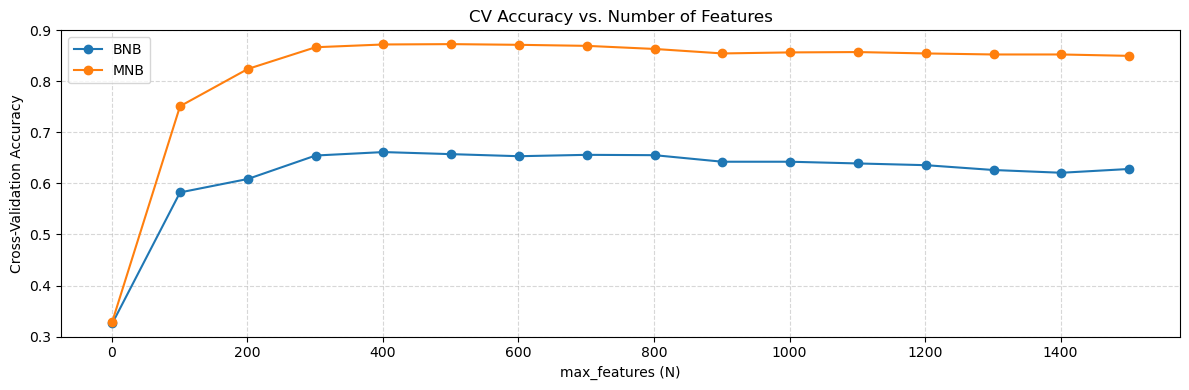

In [13]:
Ns = list(range(1, 1502, 100))
results = []

# get averaged metrics result using different N
for N in Ns:
    vect = CountVectorizer(max_features=N)
    pipe_bnb = Pipeline([('vect', vect), ('clf', BernoulliNB())])
    score_bnb = cross_val_score(pipe_bnb, X, y, cv=cv, scoring='accuracy').mean()
    pipe_mnb = Pipeline([('vect', vect), ('clf', MultinomialNB())])
    score_mnb = cross_val_score(pipe_mnb, X, y, cv=cv, scoring='accuracy').mean()
    results.append({'N': N, 'BNB': score_bnb, 'MNB': score_mnb})

df_res = pd.DataFrame(results).set_index('N')
print(df_res)

# plot
fig, ax = plt.subplots(figsize=(12, 4))
df_res.plot(kind='line', marker='o', ax=ax)
ax.set_title('CV Accuracy vs. Number of Features')
ax.set_xlabel('max_features (N)')
ax.set_ylabel('Cross-Validation Accuracy')
ax.set_ylim(0.3, 0.9)
ax.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

__Question 5__

The main reason to choose Logistic Regression is it's simple and fast. Especially when we have a music dataset, song lyrics always have a large vocabulary but most words appear only a few times, therefore, logistic regression can quickly learns and categorize which words are in certain topics. It also directly outputs the probability that each song belongs to each topic, which is efficient for recommandation.

I choose to use the default setting since our BNB and MNB also uses the default setting. Since we are comparing to the two methods before, I'm not change the N in the CountVectorizer(). I also put the BNB and MNB data attained before, for easier comparison.

In [15]:
from sklearn.linear_model import LogisticRegression

# Get cross‐validation predictions for LR
pipe_lr = Pipeline([
    ('vect', CountVectorizer()),
    ('clf', LogisticRegression()),
])
cv_pred_lr = cross_val_predict(pipe_lr, X, y, cv=cv)
socres_lr = cross_val_score(pipe_lr, X, y, cv=cv, scoring='accuracy')

# Compute four averaged metrics
lr_acc = socres_lr.mean()
lr_prec = precision_score(y, cv_pred_lr, average='macro', zero_division=0)
lr_recall = recall_score(y, cv_pred_lr, average='macro', zero_division=0)
lr_f1 = f1_score(y, cv_pred_lr, average='macro', zero_division=0)

# Build the same style DataFrame as before
df_lr_metrics = pd.DataFrame({
    'Accuracy': [bnb_acc, mnb_acc, lr_acc],
    'Precision': [bnb_prec, mnb_prec, lr_prec],
    'Recall': [bnb_recall, mnb_recall, lr_recall],
    'F1-score': [bnb_f1, mnb_f1, lr_f1],
}, index=['BernoulliNB','MultinomialNB','LogisticRegression'])

display(df_lr_metrics)

,Accuracy,Precision,Recall,F1-score
BernoulliNB,0.538514,0.533122,0.394069,0.357475
MultinomialNB,0.814865,0.829740,0.734987,0.760786
LogisticRegression,0.875000,0.874014,0.835876,0.852500


### Part 2

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Split train and test dataset
df_train = df.iloc[:750].reset_index(drop=True)
df_test = df.iloc[750:1000].reset_index(drop=True)

#Train using Logistic Regression
pipe_best = Pipeline([
    ('vect', CountVectorizer(max_features=400)),
    ('clf', LogisticRegression())
])
pipe_best.fit(df_train['lyrics_cleaned'], df_train['topic'])
preds_train = pipe_best.predict(df_train['lyrics_cleaned'])
preds_test = pipe_best.predict(df_test['lyrics_cleaned'])

# Build TF-IDF vectorizers
topic_vectorizers = {}
for topic in pipe_best.classes_:
    docs = df_train.loc[preds_train == topic, 'lyrics_cleaned']
    vect = TfidfVectorizer()
    if len(docs) > 0:
        vect.fit(docs)
    topic_vectorizers[topic] = vect

def build_user_profile(user_file):
    # get the topic, also skip the header line
    user_profile = pd.read_csv(user_file, sep='\t', header=None, names=['topic','keywords'], skiprows=1)
    user_profile['topic'] = user_profile['topic'].astype(str).str.strip()
    profiles = {}

    # Iterate over topic
    for _, row in user_profile.iterrows():
        topic = row['topic']

        # Create a boolean for documents that have the correct predicted topic
        bool = (preds_train == topic)

        # get all the liked songs and combine into one big string
        liked_song = df_train.loc[bool, 'lyrics_cleaned']
        combined_liked_song = " ".join(liked_song)

        # convert document into matrix and then convert matrix into 1D vector
        vect = topic_vectorizers[topic]
        vec = vect.transform([combined_liked_song]).toarray().ravel()

        # get the top 20 words and stores them
        top_idx = np.argsort(vec)[-20:][::-1]
        top_words = np.array(vect.get_feature_names_out())[top_idx]
        profiles[topic] = ", ".join(top_words.tolist())
        
    return profiles

# Generate profiles for User
profiles_user1 = build_user_profile('user1.tsv')
profiles_user2 = build_user_profile('user2.tsv')
profiles_user3 = build_user_profile('user3.tsv')

# Convert to DataFrame for display
df_u1 = pd.DataFrame.from_dict(profiles_user1, orient='index', columns=['Top 20 Words for User 1'])
df_u2 = pd.DataFrame.from_dict(profiles_user2, orient='index', columns=['Top 20 Words for User 2'])
df_u3 = pd.DataFrame.from_dict(profiles_user3, orient='index', columns=['Top 20 Words for User 3'])
display(df_u1)
display(df_u2)
display(df_u3)

,Top 20 Words for User 1
dark,"na, stand, come, like, know, head, blood, fight, black, gon, hand, feel, tell, kill, evil, yeah, time, grind, caus, wan"
sadness,"fall, break, heart, na, away, leav, like, know, come, yeah, think, insid, feel, gon, wan, caus, time, babi, walk, hurt"
personal,"life, live, chang, world, thank, na, yeah, know, day, believ, time, like, teach, want, need, wan, good, give, promis, reason"
lifestyle,"song, home, sing, time, tonight, night, come, na, long, right, know, wait, blue, wan, mind, closer, like, yeah, stranger, play"
emotion,"good, go, hold, touch, feel, hand, know, lip, want, vision, darl, morn, heart, luck, video, loov, yeah, come, vibe, feelin"


,Top 20 Words for User 2
sadness,"fall, break, heart, na, away, leav, like, know, come, yeah, think, insid, feel, gon, wan, caus, time, babi, walk, hurt"
emotion,"good, go, hold, touch, feel, hand, know, lip, want, vision, darl, morn, heart, luck, video, loov, yeah, come, vibe, feelin"


,Top 20 Words for User 3
dark,"na, stand, come, like, know, head, blood, fight, black, gon, hand, feel, tell, kill, evil, yeah, time, grind, caus, wan"
sadness,"fall, break, heart, na, away, leav, like, know, come, yeah, think, insid, feel, gon, wan, caus, time, babi, walk, hurt"
personal,"life, live, chang, world, thank, na, yeah, know, day, believ, time, like, teach, want, need, wan, good, give, promis, reason"
lifestyle,"song, home, sing, time, tonight, night, come, na, long, right, know, wait, blue, wan, mind, closer, like, yeah, stranger, play"
emotion,"good, go, hold, touch, feel, hand, know, lip, want, vision, darl, morn, heart, luck, video, loov, yeah, come, vibe, feelin"


__Question 1__

For all three users, most of the words look reasonable to me, but there is still some noise like "gon", "na", "yeah" in the topic dark, which does not make any sense. Since we can't use keywords when we are doing recommendations, it is reasonable that we have some noise here. I put only three keywords for each topic in user3, so the performance may not be as good as user1. But overall, the words are quite coherent.

In [21]:
def build_profile_new(user_file, M=None):
    # get the topic, also skip header line
    user_profile = pd.read_csv(user_file, sep='\t', header=None, names=['topic','keywords'], skiprows=1)
    user_profile['topic'] = user_profile['topic'].astype(str).str.strip()
    profiles = {}

    # Iterate over topic
    for _, row in user_profile.iterrows():
        topic = row['topic']

        # Create a boolean for documents have correct predicted topic
        bool = (preds_train == topic)
        
        # get all the liked songs and combine into one big string
        liked_song = df_train.loc[bool, 'lyrics_cleaned']
        combined_liked_song = " ".join(liked_song)
        
        # convert document into matrix and then convert matrix into 1D vector
        vect = topic_vectorizers[topic]
        vec = vect.transform([combined_liked_song]).toarray().ravel()

        # get the vector from the top-M weights
        if M and M < vec.size:
            idx = np.argsort(vec)[-M:]
            sparse = np.zeros_like(vec)
            sparse[idx] = vec[idx]
            profiles[topic] = sparse
        else:
            profiles[topic] = vec

    return profiles


N = 15
M_values = [10, 50, 100, 200, None]
users = {'User1':'user1.tsv', 'User2':'user2.tsv', 'User3':'user3.tsv'}
results = []

for user_label, user_file in users.items():
    for M in M_values:
        profile = build_profile_new(user_file, M)
        sims_cos, sims_euc, sims_jac = [], [], []
        bool_result = []
        
        # iterate each test song
        for i, txt in enumerate(df_test['lyrics_cleaned']):
            # get vector
            pred_topic = preds_test[i]
            topic_vect = topic_vectorizers[pred_topic]
            song_vec = topic_vect.transform([txt]).toarray().ravel()
            profile_vec = profile.get(pred_topic, np.zeros_like(song_vec))

            # Cosine similarity and make it 1-D array
            cos = cosine_similarity([song_vec], [profile_vec])[0,0]
            sims_cos.append((i, cos))
        
            # Euclidean
            dist = np.linalg.norm(song_vec - profile_vec)
            euc = 1.0 / (1.0 + dist)
            sims_euc.append((i, euc))
        
            # Jaccard
            num = np.minimum(song_vec, profile_vec).sum()
            den = np.maximum(song_vec, profile_vec).sum()
            jac = num / den if den > 0 else 0.0
            sims_jac.append((i, jac))

            # user keywords in it
            keyword_df = pd.read_csv(user_file, sep='\t', header=None, names=['topic','keywords'], skiprows=1)
            keywords = []
            for _, row in keyword_df.iterrows():
                if row['topic'].strip() == pred_topic:
                    keywords = [w.strip() for w in row['keywords'].lower().split(',') if w.strip()]
                    break
            bool_result.append(any(keyword in txt.split() for keyword in keywords))

        # get all the metrics
        metrics = {
            'cosine' : sims_cos,
            'euclidean': sims_euc,
            'jaccard': sims_jac
        }
        for metric_name, sims in metrics.items():
            top_idxs = [idx for idx, _ in sorted(sims, key=lambda x: x[1], reverse=True)[:N]]
            precision = sum(bool_result[i] for i in top_idxs) / N
            total_relevant = sum(bool_result)
            recall = sum(bool_result[i] for i in top_idxs) / total_relevant if total_relevant>0 else np.nan
            f1 = 2*precision*recall/(precision+recall) if (precision+recall)>0 else np.nan

            results.append({
                'User': user_label,
                'M': M or 'all',
                'Metric': metric_name,
                'Precision': precision,
                'Recall': recall,
                'F1': f1
            })

# display the result
results_df = pd.DataFrame(results)
for user_label in results_df['User'].unique():
    user_df = results_df[results_df['User'] == user_label]
    print(f"----- {user_label} -----")
    display(user_df.drop(columns=['User']))

----- User1 -----


,M,Metric,Precision,Recall,F1
0,10,cosine,0.466667,0.0875,0.147368
1,10,euclidean,0.466667,0.0875,0.147368
2,10,jaccard,0.466667,0.0875,0.147368
3,50,cosine,0.600000,0.1125,0.189474
4,50,euclidean,0.600000,0.1125,0.189474
5,50,jaccard,0.466667,0.0875,0.147368
6,100,cosine,0.666667,0.1250,0.210526
7,100,euclidean,0.600000,0.1125,0.189474
8,100,jaccard,0.533333,0.1000,0.168421
9,200,cosine,0.600000,0.1125,0.189474


----- User2 -----


,M,Metric,Precision,Recall,F1
15,10,cosine,0.066667,0.2,0.1
16,10,euclidean,0.066667,0.2,0.1
17,10,jaccard,0.066667,0.2,0.1
18,50,cosine,0.066667,0.2,0.1
19,50,euclidean,0.066667,0.2,0.1
20,50,jaccard,0.066667,0.2,0.1
21,100,cosine,0.066667,0.2,0.1
22,100,euclidean,0.066667,0.2,0.1
23,100,jaccard,0.066667,0.2,0.1
24,200,cosine,0.066667,0.2,0.1


----- User3 -----


,M,Metric,Precision,Recall,F1
30,10,cosine,0.066667,0.027027,0.038462
31,10,euclidean,0.133333,0.054054,0.076923
32,10,jaccard,0.066667,0.027027,0.038462
33,50,cosine,0.066667,0.027027,0.038462
34,50,euclidean,0.133333,0.054054,0.076923
35,50,jaccard,0.066667,0.027027,0.038462
36,100,cosine,0.066667,0.027027,0.038462
37,100,euclidean,0.066667,0.027027,0.038462
38,100,jaccard,0.066667,0.027027,0.038462
39,200,cosine,0.066667,0.027027,0.038462


__Question 2__

I chose N = 15 for all songs. I don't think giving them a hundred songs is a good idea; it will increase recall and decrease precision greatly. The user will not like all those songs. And I think a small number of songs is good, there will be a great chance it leads to high precision but low recalls, you recommend songs the user likes, the problem is just missing a lot of other songs the user also likes. But the recommender's point is to recommend things users like and make them keep using your app or website, so I think precision is quite important here. The same reason is applied for the metrics choice, precision is the one that matters most.

I also tried out different values of M, as you can see in the above table, it doesn't show an overall increasing or decreasing trend, more like a fluctuation. For user1, M = 100 maximize the precision.

User 1 has moderate precision, and low Recall. User 2 has high Recall than user1, but very low Precision, less than 0.1, which means they recommend many irrelevant songs. User 3 has low precision and recall. I'm assuming one of the reasons could be that I only give each topic three words, and some of the keywords I choose are not in the lyrics, which leads to poor performance.

I recommend using the cosine similarity as the best algorithm, the Euclidean distance needs normalization to perform better. The cosine similarity only focuses on the directions, not the value of the vector, which is good for content-based recommenders.

### part 3

I asked my friend at USYD to complete my recommendation system, he focuses on the frontend and has zero knowledge of recommendation systems or machine learning. I use N=15, which means he reviews 15 songs as one batch for a total of three batches. Each batch is randomly chosen from each week's 250 songs. After reviewing the lyrics, he chose 11 songs from 45 that seemed interesting to him.
I used the recommender system in part 2 to generate the top 15 songs he might like, and he told me he likes 11 songs among all 15 songs. After calculating the precision, 11/15 = 0.733, it turns out the result is way higher than the part 2 result.
I think part of the reason is, when they read the lyrics, they are understanding it better than computers. When computers do tokenization and embeddings, it doesn't care about the word meaning; people have human judgment, and the tone and phrasing will greatly affect the result. And also, people are biased when they take surveys or experiments like this. They tend to perform better in the experiment, which makes the recommender look useful.